In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isfile, join, basename
%matplotlib inline

In [2]:
fig_dir = r"C:\Users\Fabusuyi\Documents\Work _UCT\PG\Write_Up\figs\load_paper"
def save_figure(fname, obj, dir=fig_dir):
    """wrapper to save figure in desied directory"""
    path = os.path.join(os.path.normpath(fig_dir), fname)
    obj.savefig(path)

In [3]:
class ExpDataStruct:
    def __init__(self):
        self.curr_dens = 0
        self.temp = 0
        self.humidity = 0
        self.data = 0
        self.params = 0
        self.pol_fwd = 0
        self.pol_rev = 0
        self.name = ''

In [4]:
def get_data(filename):
    """
This method helps to retrieve data from existing
excel file with full pathname "filename"
    """
    dt = pd.read_excel(filename, sheetname=0, header=None,)
    df = pd.DataFrame(data=dt, index=None)

    # check for the file type
    if df.iloc[0, 0] == 'Current density (mA/cm2)':  # this is EIS data

        eis_data = ExpDataStruct()  # initializes the struct for eis_data

        name = basename(filename)
        curr_dens = df.iloc[0, 1]  # grabs the current density for the EIS data
        col_name = df.iloc[1, :].tolist()

        # clean eis data
        data = df
        data.columns = col_name
        data = data.dropna(how='any')
        data = data[1:]
        data = data.reset_index(drop=True)

        # populate the eis_data struct
        eis_data.data = data
        eis_data.curr_dens = curr_dens
        eis_data.name = name

        exp_data = eis_data  # assign populated eis_data struct to return variable

    elif df.iloc[0, 0] == 'Set point values':  # this is polarisation curve data

        pol_data = ExpDataStruct()

        # clean parameter portion of the data
        params = df.iloc[:, 0:2]
        params = params.dropna(how='any')
        params.columns = ['set point', 'value']
        params = params.reset_index(drop=True)
        
        name = basename(filename)
        
        # clean pol_fwd portion of the data
        pol_fwd = df.iloc[:, 3:9]
        pol_fwd = pol_fwd.dropna(how='any')
        pol_fwd.columns = ['cell temp C', 'curr_den', 'v1', 'v2', 'v3', 'avg_volt']
        pol_fwd = pol_fwd.reset_index(drop=True)

        # clean pol_reverse portion of the data
        pol_rev = df.iloc[:, 10:16]
        pol_rev = pol_rev.dropna(how='any')
        pol_rev.columns = ['cell temp C', 'curr_den', 'v1', 'v2', 'v3', 'avg_volt']
        pol_rev = pol_rev.reset_index(drop=True)

        # populate the pol_data struct
        pol_data.params = params
        pol_data.pol_fwd = pol_fwd
        pol_data.pol_rev = pol_rev
        pol_data.name = name

        exp_data = pol_data  # assign populated pol_data struct to return variable

    return exp_data

In [5]:
data_dir = r"C:\Users\Fabusuyi\Documents\Work _UCT\PG\Data\new_data\exp\my_data"
eis_path_fuelcon = os.path.join(os.path.normpath(data_dir), '29_4_2018 EIS at 100mAcm-2 air ID1.xlsx')
eis_fuel_con = get_data(eis_path_fuelcon).data

# soup
rng = np.random.RandomState(42)
sd = 0.15
re_ck = rng.normal(loc=0, scale=sd, size=len(eis_fuel_con))
im_ck = rng.normal(loc=0, scale=sd, size=len(eis_fuel_con))
eis_fuel_con['re_ck'] = eis_fuel_con['Imp Re'] + re_ck
eis_fuel_con['im_ck'] = eis_fuel_con['Imp i'] + im_ck
eis_fuel_con.head()

,Frequency (Hz),Imp Re,Imp i,re_ck,im_ck
0,0.3,24.04,0.36,24.1145,0.407137
1,0.7,24.02,1.64,23.9993,1.5038
2,1.5,23.42,3.79,23.5172,3.57815
3,3.1,20.85,6.57,21.0785,6.78985
4,6.3,16.15,8.08,16.1149,8.04613


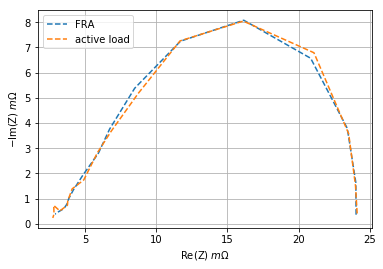

In [6]:
fig, ax = plt.subplots()
ax.plot(eis_fuel_con['Imp Re'], eis_fuel_con['Imp i'], '--', label='FRA')
ax.plot(eis_fuel_con['re_ck'], eis_fuel_con['im_ck'], '--', label='active load')

ax.set_xlabel('Re(Z) $m\Omega$')
ax.set_ylabel('$\minus$Im(Z) $m\Omega$')
ax.grid('on')
ax.legend()

In [7]:
save_figure("eis_load_fra.png", fig)